# Plotting 

In [7]:

import os
import json
from glob import glob
from collections import defaultdict


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt

In [8]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)


# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

## Figure Budget


Plotting PSNR

Checking mesh file: data/hotdog/area_1_occlusion/per_view_gs_mesh.json
File exists: True
Available keys: ['ours_1']
Pure Mesh - PSNR: mean=28.9337, std=1.5587, n=200

Processing Area-based budgeting:
  Checking: per_view_gs_mesh.json, exists: True
    Budget 40000: mean=29.8391, std=1.5771, splats=40000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 80000: mean=30.8810, std=1.6597, splats=80000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 160000: mean=32.5369, std=2.0155, splats=160000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 320000: mean=34.1650, std=2.6810, splats=320000
  Plotting 4 area points

Processing Distortion-based budgeting:
  Checking: per_view_gs_mesh.json, exists: True
    Budget 40000: mean=30.7906, std=1.5475, splats=40000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 80000: mean=31.8997, std=1.8147, splats=80000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 160000: mean=33.2167, std=

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: PSNR_vs_budget_hotdog.png and .eps



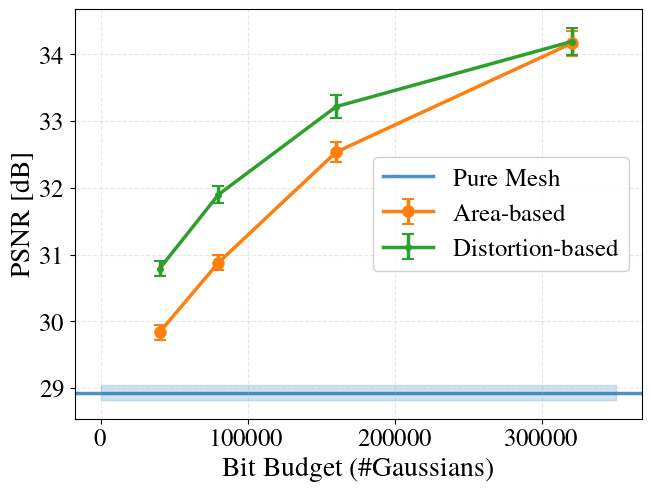


Plotting SSIM

Checking mesh file: data/hotdog/area_1_occlusion/per_view_gs_mesh.json
File exists: True
Available keys: ['ours_1']
Pure Mesh - SSIM: mean=0.9528, std=0.0064, n=200

Processing Area-based budgeting:
  Checking: per_view_gs_mesh.json, exists: True
    Budget 40000: mean=0.9555, std=0.0069, splats=40000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 80000: mean=0.9606, std=0.0066, splats=80000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 160000: mean=0.9687, std=0.0050, splats=160000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 320000: mean=0.9773, std=0.0035, splats=320000
  Plotting 4 area points

Processing Distortion-based budgeting:
  Checking: per_view_gs_mesh.json, exists: True
    Budget 40000: mean=0.9603, std=0.0063, splats=40000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 80000: mean=0.9652, std=0.0049, splats=80000
  Checking: per_view_gs_mesh.json, exists: True
    Budget 160000: mean=0.9719, std=0.0036, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Saved: SSIM_vs_budget_hotdog.png and .eps



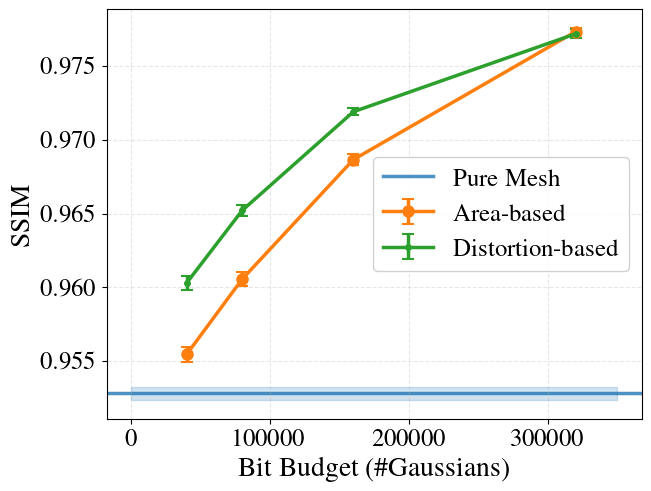

In [15]:

def budget_policy_curves():
    """
    Plot metrics vs budget for different budgeting policies.
    
    - Pure mesh (horizontal line) - area_1_occlusion
    - Area-based budgeting - area_*_occlusion (40k, 80k, 160k, 320k)
    - Distortion-based budgeting - distortion_*_occlusion (40k, 80k, 160k, 320k)
    """
    SCENE_NAME = 'hotdog'
    ITERATION = 'ours_15000'  # Last iteration for GS+Mesh
    MESH_ITERATION = 'ours_1'  # Pure mesh uses different key
    
    input_dir = Path('./data') / SCENE_NAME
    output_dir = Path('./plots') / 'budget_policy_curves' / SCENE_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define policies and their budgets
    budgets = [40000, 80000, 160000, 320000]
    
    # Quality Metrics to plot
    metrics = {
        'PSNR': {'ylabel': 'PSNR [dB]', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        # 'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'}
        # [TODO] draw LPIPS soon
        
    }
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        print(f"\n{'='*60}")
        print(f"Plotting {metric_key}")
        print(f"{'='*60}")
        
        # 1. Pure mesh, no gaussians (horizontal line) - area_1_occlusion
        mesh_file = input_dir / 'area_1_occlusion' / 'per_view_gs_mesh.json'
        print(f"\nChecking mesh file: {mesh_file}")
        print(f"File exists: {mesh_file.exists()}")
        
        if mesh_file.exists():
            with open(mesh_file, 'r') as f:
                data = json.load(f)
            
            print(f"Available keys: {list(data.keys())}")
            
            # Try mesh iteration key first, then regular iteration key
            iter_key = MESH_ITERATION if MESH_ITERATION in data else ITERATION
            
            if iter_key in data:
                metric_data = data[iter_key][metric_key]
                if isinstance(metric_data, dict):
                    values = [v for v in metric_data.values() if v != -1.0]
                else:
                    values = [metric_data]
                
                mean_val = np.mean(values)
                std_val = np.std(values)
                stderr = std_val / np.sqrt(len(values))
                
                # Plot horizontal line spanning the budget range
                ax.axhline(y=mean_val, color=color_palette[0], linestyle='-', 
                          linewidth=2.5, label='Pure Mesh', alpha=0.8, zorder=1)
                ax.fill_between([0, 350000], mean_val - stderr, mean_val + stderr, 
                               color=color_palette[0], alpha=0.2, zorder=1)
                
                print(f"Pure Mesh - {metric_key}: mean={mean_val:.4f}, std={std_val:.4f}, n={len(values)}")
            else:
                print(f"Neither {MESH_ITERATION} nor {ITERATION} found in mesh file")
        
        # 2. Area-based budgeting
        area_xs = []
        area_ys = []
        area_errs = []
        
        print(f"\nProcessing Area-based budgeting:")
        for budget in budgets:
            area_file = input_dir / f'area_{budget}_occlusion' / 'per_view_gs_mesh.json'
            print(f"  Checking: {area_file.name}, exists: {area_file.exists()}")
            
            if area_file.exists():
                with open(area_file, 'r') as f:
                    data = json.load(f)
                
                if ITERATION in data:
                    metric_data = data[ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    num_splats = data[ITERATION].get('num_splats', budget)
                    
                    area_xs.append(num_splats)
                    area_ys.append(mean_val)
                    area_errs.append(stderr)
                    
                    print(f"    Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"    {ITERATION} not found in {area_file.name}")
        
        if area_xs:
            print(f"  Plotting {len(area_xs)} area points")
            ax.errorbar(area_xs, area_ys, yerr=area_errs,
                       marker='o', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[1], label='Area-based', zorder=2)
        else:
            print("  No area data to plot!")
        
        # 3. Distortion-based budgeting
        dist_xs = []
        dist_ys = []
        dist_errs = []
        
        print(f"\nProcessing Distortion-based budgeting:")
        for budget in budgets:
            dist_file = input_dir / f'distortion_{budget}_occlusion' / 'per_view_gs_mesh.json'
            print(f"  Checking: {dist_file.name}, exists: {dist_file.exists()}")
            
            if dist_file.exists():
                with open(dist_file, 'r') as f:
                    data = json.load(f)
                
                if ITERATION in data:
                    metric_data = data[ITERATION][metric_key]
                    if isinstance(metric_data, dict):
                        values = [v for v in metric_data.values() if v != -1.0]
                    else:
                        values = [metric_data]
                    
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    stderr = std_val / np.sqrt(len(values))
                    num_splats = data[ITERATION].get('num_splats', budget)
                    
                    dist_xs.append(num_splats)
                    dist_ys.append(mean_val)
                    dist_errs.append(stderr)
                    
                    print(f"    Budget {budget}: mean={mean_val:.4f}, std={std_val:.4f}, splats={num_splats}")
                else:
                    print(f"    {ITERATION} not found in {dist_file.name}")
        
        if dist_xs:
            print(f"  Plotting {len(dist_xs)} distortion points")
            ax.errorbar(dist_xs, dist_ys, yerr=dist_errs,
                       marker='.', markersize=8, linewidth=2.5,
                       capsize=err_capsize, capthick=err_capthick,
                       color=color_palette[2], label='Distortion-based', zorder=2)
        else:
            print("  No distortion data to plot!")
        
        # Formatting
        ax.set_xlabel('Bit Budget (\#Gaussians)', fontsize=20)
        ax.set_ylabel(metric_info['ylabel'], fontsize=20)
        # ax.set_title(f"{metric_info['title']} vs. Budget ({SCENE_NAME})", fontsize=22)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_vs_budget_{SCENE_NAME}'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\nSaved: {base_name}.png and .eps\n")
        
        plt.show()
        plt.close()


budget_policy_curves()

## Figure Iter

In [10]:

def policy_iter_curves():
    """
    Plot metrics vs budget for different policies using JSON data
    """
    # Configuration
    EXPERIMENT_DATE = "1116_nerfsynthetic"
    SCENE_NAME = "hotdog"
    MESH_TYPE = "area_75000_occlusion"
    
    input_file = Path(f'output/{EXPERIMENT_DATE}/{SCENE_NAME}/{MESH_TYPE}/per_view_gs_mesh.json')
    output_dir = Path(f'output/{EXPERIMENT_DATE}/figure_policy')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load JSON data
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    print(f"Loaded data with {len(data)} iterations")
    
    # Extract data for each iteration
    iterations = sorted(data.keys(), key=lambda x: int(x.split('_')[1]))
    print(f"Iterations: {iterations}")
    
    # Metrics to plot
    metrics = {
        'PSNR': {'ylabel': 'PSNR [dB]', 'title': 'PSNR'},
        'SSIM': {'ylabel': 'SSIM', 'title': 'SSIM'},
        'LPIPS': {'ylabel': 'LPIPS', 'title': 'LPIPS'}
    }
    
    # Plot each metric
    for metric_key, metric_info in metrics.items():
        fig, ax = plt.subplots(figsize=figsize)
        
        xs = []
        ys = []
        
        for iteration in iterations:
            # Extract iteration number
            iter_num = int(iteration.split('_')[1])
            xs.append(iter_num)
            
            # Calculate mean of metric across all views
            metric_data = data[iteration][metric_key]
            if isinstance(metric_data, dict):
                # Per-view data - calculate mean
                values = [v for v in metric_data.values() if v != -1.0]
                mean_val = np.mean(values) if values else 0
                ys.append(mean_val)
                print(f"{metric_key} @ {iteration}: {len(values)} views, mean={mean_val:.4f}")
            else:
                # Single value
                ys.append(metric_data)
                print(f"{metric_key} @ {iteration}: {metric_data:.4f}")
        
        print(f"\n{metric_key} - X values: {xs}")
        print(f"{metric_key} - Y values: {ys}\n")
        
        # Plot line
        ax.plot(xs, ys, 
               marker='o', 
               linestyle='-', 
               linewidth=2.5, 
               markersize=7,
               color=color_palette[0],
               label=SCENE_NAME)
        
        # Formatting - use raw string for hash
        ax.set_xlabel(r'Iterations', fontsize=20)  # Removed \# to avoid LaTeX issues
        ax.set_ylabel(metric_info['ylabel'], fontsize=20)
        ax.set_title(f"{metric_info['title']} vs. Iterations", fontsize=22)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', framealpha=0.9, fontsize=18)
        ax.tick_params(labelsize=18)
        
        # Use constrained_layout instead of tight_layout to avoid LaTeX issues
        fig.set_constrained_layout(True)
        
        # Save both formats
        base_name = f'{metric_key}_vs_iterations'
        plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"Saved: {base_name}.png and .eps")
        
        plt.show()
        plt.close()


# policy_iter_curves()